<a href="https://colab.research.google.com/github/varmatilak22/learning_tensorflow/blob/main/06_transfer_learning_in_tensorflow_part_3_Scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning With Tensorflow Part 3: Scaling Up (🍔👀Food Vision Mini)
Weve seen the power of transfer learning feature extraction and fine-tunning,now its time to scale up to all of the classes in Food101(101 food classes of food).

Our Goal is to beet the original Food101 Paper with the 10% of the training (leveraging the power of transfer learning or deep learning).

Original Food101 Paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf.

Our baseline is to beat 50.76% accuracy accross 101 classes.

In [ ]:
#Check to see if we're using a GPU
!nvidia-smi

Tue Jul 30 08:32:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

In previous notebook, we've created series of helper functions to do different task,lets download them.

In [ ]:
!wget https://raw.githubusercontent.com/varmatilak22/learning_tensorflow/main/extras/helper_func.py

--2024-07-30 08:32:35--  https://raw.githubusercontent.com/varmatilak22/learning_tensorflow/main/extras/helper_func.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13288 (13K) [text/plain]
Saving to: ‘helper_func.py’

helper_func.py      100%[===================>]  12.98K  --.-KB/s    in 0.001s  

2024-07-30 08:32:36 (21.1 MB/s) - ‘helper_func.py’ saved [13288/13288]



In [ ]:
#Import a series of helper functions
from helper_func import plot_loss_curves,create_tensorboard_callback,walk_through_dir,unzip_data,compare_historys

## 101 Food Classes:Working with less data
Our goal is to beat the original Food101 paper with 10% of the training data, so lets download it.

The data we;re downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook:https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
#Load the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

#Unzip the data using helper function
unzip_data("101_food_classes_10_percent.zip")

#Global Variables
IMG_SIZE=(224,224)
EPOCHS=5

#Directory path
train_dir='101_food_classes_10_percent/train/'
test_dir='101_food_classes_10_percent/test/'

from tensorflow.keras.preprocessing import  image_dataset_from_directory

train_data=image_dataset_from_directory(directory=train_dir,
                                        label_mode='categorical',
                                        image_size=IMG_SIZE,
                                        shuffle=False)

test_data=image_dataset_from_directory(directory=train_dir,
                                       label_mode='categorical',
                                       image_size=IMG_SIZE,
                                       ) #Do not shuffle the data for prediction analysis

--2024-07-30 08:32:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  70.8MB/s    in 20s     

2024-07-30 08:33:10 (76.4 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]

Found 7575 files belonging to 101 classes.
Found 7575 files belonging to 101 classes.


In [ ]:
#How many classes are there?
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pancakes'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/dumplings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/spring_rolls'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/garlic_bread'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food

## Train a big dog model with transfer learning on 10% of Food 101 food classes.

Here are the steps we're going to take:
* Create a ModelCheckpoint Callback
* Create a Data Augmentation layer to build data augmentation right into the model.
* Build headless (no top layers) functional EfficientNetB0 backboned_model (we'll create our own output layer).
* Compile the model
* Feature Extraction for 5 full passes (5 Epochs on train dataset and validate on 15% of the test data,to save epoch time.)


In [ ]:
#Create modelcheckpoint callback
checkpoint_path='101_classes_10_percent_data_model_checkpoints/checkpoint.ckpt'

def model_checkpoint_callback(checkpoint_path):
  """
  function to create a model checkpoint callback
  here it will be used to load the weights of a trained model for fint tunning.
  """
  modelcheckpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                                   moniter='val_accuracy',
                                                                   save_best_only=True,
                                                                   save_weights_only=True,
                                                                   save_freq='epoch',
                                                                   verbose=1)
  return modelcheckpoint_callback

In [ ]:
import tensorflow as tf

In [ ]:
#Create data augmentation layer to incorporate it right into the model
from tensorflow.keras.layers import RandomFlip,RandomZoom,RandomHeight,RandomRotation,RandomWidth,Rescaling

data_augmentation=tf.keras.models.Sequential([
    RandomFlip('horizontal'),
    RandomHeight(0.2),
    RandomZoom(0.2),
    RandomWidth(0.2),
    RandomWidth(0.2),
    RandomRotation(0.2), #Efficient Net model does not need rescaling
   #Rescaling(1/255) #required for models like ResNet50
],name='Data_Augmentation_layer')

🔑**Notes:** I have created a helper function(`create_data_aug`) for data augmentation in `helper_func.py` file.

In [ ]:
#Setup the base_model and freeze the layers (this will extract features)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

#Create the Model
# 1. Create a input layer
input_layer=tf.keras.layers.Input(shape=IMG_SIZE+(3,),
                                  name='Input_layer')
print('Input Shape:',input_layer.shape)

# 2. Add a data_augmentation layer
x=data_augmentation(input_layer)
print("Data Augmentation:",x.shape)

# 3. Adding a base_model we created earlier in the code
x=base_model(x,training=False)
print("Base_model Shape:",x.shape)

# 4. Adding a Pooling layer in the functional API we used GlobalAveragePooling2D which convert the 4D tensor to 2DTensor.
x=tf.keras.layers.GlobalAveragePooling2D()(x)
print("Pooling layr:",x.shape)

# 5. Create a Output layer
output_layer=tf.keras.layers.Dense(101,activation='softmax')(x)
print("Outpur Layer:",output_layer.shape)

# 6. Combine the input and output layer
model=tf.keras.Model(input_layer,output_layer)

16705208/16705208 [==============================] - 0s 0us/step
Input Shape: (None, 224, 224, 3)
Data Augmentation: (None, None, None, 3)
Base_model Shape: (None, None, None, 1280)
Pooling layr: (None, 1280)
Outpur Layer: (None, 101)


In [ ]:
#Get the summary of the model we created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Data_Augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                             

In [ ]:
#Comile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

#fit the model
history_all_classes_10_percent=model.fit(train_data,
          epochs=EPOCHS,
          steps_per_epoch=len(train_data),
          validation_data=test_data,
          validation_steps=int(0.15*len(test_data)),
          callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                 experiment_name='all_classes_10_percent_feature_extraction'),model_checkpoint_callback(checkpoint_path)])

Saving TensorBoard log files to: transfer_learning/all_classes_10_percent_feature_extraction/20240730-083335
Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.4322 - accuracy: 0.2609
Epoch 1: val_loss improved from inf to 2.44110, saving model to 101_classes_10_percent_data_model_checkpoints/checkpoint.ckpt
237/237 [==============================] - 177s 698ms/step - loss: 3.4322 - accuracy: 0.2609 - val_loss: 2.4411 - val_accuracy: 0.5036
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.2588 - accuracy: 0.4800
Epoch 2: val_loss improved from 2.44110 to 1.84554, saving model to 101_classes_10_percent_data_model_checkpoints/checkpoint.ckpt
237/237 [==============================] - 115s 483ms/step - loss: 2.2588 - accuracy: 0.4800 - val_loss: 1.8455 - val_accuracy: 0.5723
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8891 - accuracy: 0.5500
Epoch 3: val_loss improved from 1.84554 to 1.62349, saving model to 101_classes_

In [ ]:
## Evaluate on the whole test dataset
fine_tunning_results=model.evaluate(test_data)

237/237 [==============================] - 17s 72ms/step - loss: 1.2562 - accuracy: 0.6812


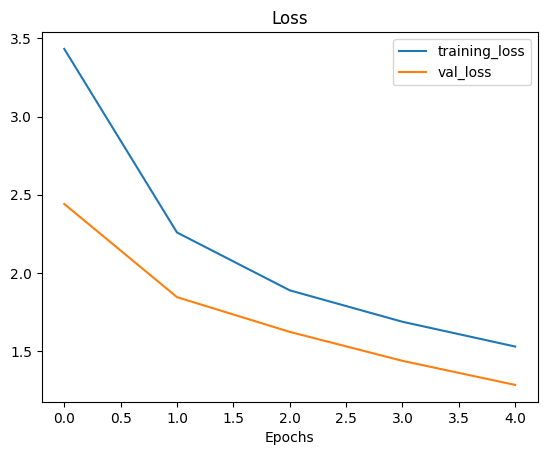

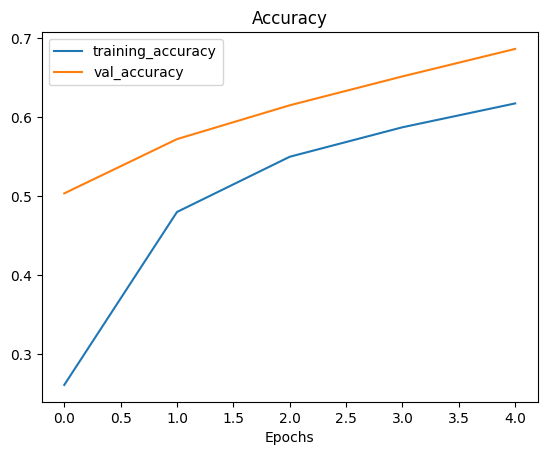

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

🔑**Notes:** What do these curves suggest? Hint:Ideally, the two curves should be be very similar to each other, if not.
Ideally Should be similar
Actual it is overfitting.
(performing too well on training data and not on generalising to unseen data.)

## Fine-tunning

In [ ]:
#Unfreeze all of the layers in the base model
base_model.trainable=True

#Refreeze every layer except the last
for layer in base_model.layers[:-5]:
  layer.trainable=False

#Checking which layers are freeze
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
#Recompile the model with lower learning rate(its typically best practice to lower the learning rate when fine-tuning)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#learning rate lower by 10%,
              metrics=['accuracy'])

In [ ]:
#Fine-tune for more 5 Epochs
initial_epochs=5 # total 10 epochs has model has been trained for 5 epoch and will fine tune for another 5 epochs
fine_tune_epochs=initial_epochs+5

#Fine-tune our model
history_all_classes_10_percent_fine_tune=model.fit(train_data,
                                                   epochs=fine_tune_epochs,
                                                   initial_epoch=initial_epochs,
                                                   steps_per_epoch=len(train_data),
                                                   validation_data=test_data,
                                                   validation_steps=int(0.15*len(test_data)),
                                                   callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                          experiment_name='all_classes_10_percent_fine_tune_last_5')])

Saving TensorBoard log files to: transfer_learning/all_classes_10_percent_fine_tune_last_5/20240730-084515
Epoch 6/10
237/237 [==============================] - 94s 363ms/step - loss: 1.3075 - accuracy: 0.6610 - val_loss: 1.1593 - val_accuracy: 0.6848
Epoch 7/10
237/237 [==============================] - 80s 336ms/step - loss: 1.1799 - accuracy: 0.6906 - val_loss: 1.0625 - val_accuracy: 0.7045
Epoch 8/10
237/237 [==============================] - 69s 288ms/step - loss: 1.1010 - accuracy: 0.7073 - val_loss: 1.0114 - val_accuracy: 0.7232
Epoch 9/10
237/237 [==============================] - 68s 284ms/step - loss: 1.0417 - accuracy: 0.7163 - val_loss: 0.9499 - val_accuracy: 0.7366
Epoch 10/10
237/237 [==============================] - 66s 276ms/step - loss: 0.9616 - accuracy: 0.7410 - val_loss: 0.9052 - val_accuracy: 0.7571


In [ ]:
#Evaluate the whole test dataset
fine_tune_all_classes_results=model.evaluate(test_data)

237/237 [==============================] - 17s 70ms/step - loss: 0.8698 - accuracy: 0.7607


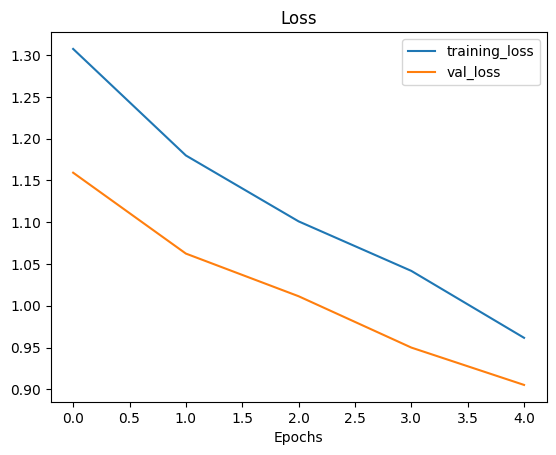

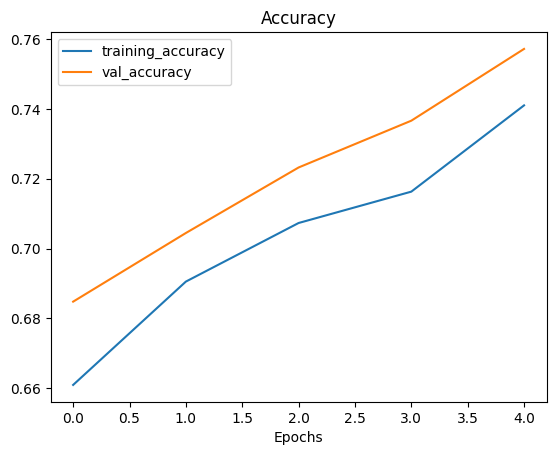

In [ ]:
plot_loss_curves(history_all_classes_10_percent_fine_tune)

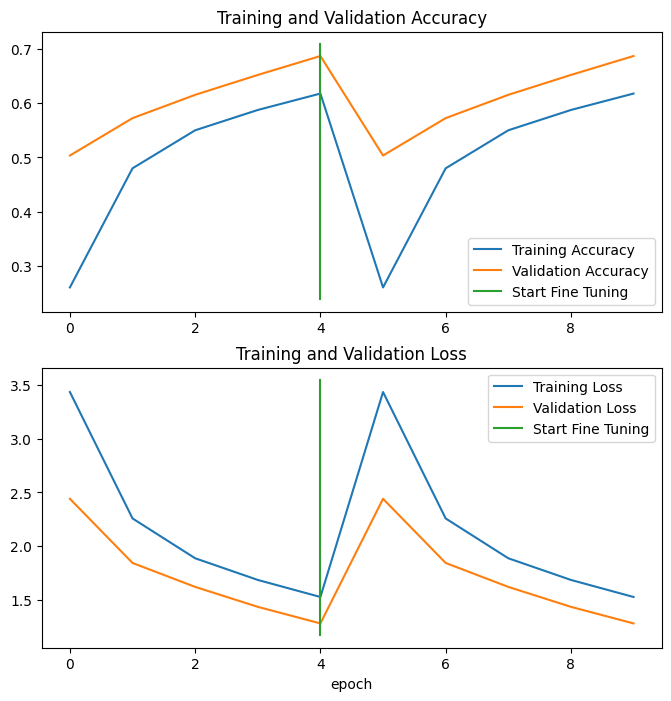

In [ ]:
#Compare historys
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent,
                 initial_epochs=5)

## Saving and loading our model

To use our model in external application, we'll need to save it and export it somewhere.

In [ ]:
#Save our fine tune model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
#Load and evaluate the model
loaded_model=tf.keras.models.load_model('drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model')

In [ ]:
#Evaluae loaded model and compare the performance to pre-saved moddel
loaded_model_results=loaded_model.evaluate(test_data)
loaded_model_results

237/237 [==============================] - 19s 74ms/step - loss: 0.8698 - accuracy: 0.7607


[0.8698236346244812, 0.7606600522994995]

In [ ]:
fine_tune_all_classes_results

[0.8698236346244812, 0.7606600522994995]

## Evaluating the performance of the big dog model across all different classes

Lets make some predictions,Visualise them and then later find out which predictions were the 'most' wrong.

In [ ]:
import tensorflow as tf

#Download pretrained model (one that was prepared earlier,so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-07-30 08:54:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 74.125.137.207, 142.250.101.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   141MB/s    in 0.3s    

2024-07-30 08:54:02 (141 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
#Unzip the data
unzip_data('06_101_food_class_10_percent_saved_big_dog_model.zip')

In [ ]:
#load in saved model
model=tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
#Evaluate the loaded model(the one we just downloaded on test data)
results_downloaded_model=model.evaluate(test_data)
results_downloaded_model

237/237 [==============================] - 19s 72ms/step - loss: 0.3607 - accuracy: 0.8892


[0.3606625497341156, 0.8892409205436707]

## Making Predictions with our trained model

In [ ]:
#Make Predictions with model
preds_prob=model.predict(test_data,verbose=1) #set verbosity to see how long is left

237/237 [==============================] - 20s 78ms/step


In [ ]:
len(test_data)

237

In [ ]:
790*32

25280

In [ ]:
#How many predictions are there?
len(preds_prob)

7575

In [ ]:
25250*101

2550250

In [ ]:
#Whats the shape of predictions?
preds_prob.shape

(7575, 101)

In [ ]:
#Lets see what the first 10 predictions look like
preds_prob[:10]

array([[8.46203625e-01, 1.11298937e-06, 6.52657434e-07, ...,
        2.43660475e-06, 7.71250052e-06, 4.77388588e-04],
       [3.43977153e-01, 8.51257553e-08, 3.59932492e-05, ...,
        1.27986930e-02, 1.93000873e-04, 6.01245537e-02],
       [9.10926282e-01, 1.36035936e-07, 1.76096655e-05, ...,
        1.37815887e-05, 9.51468877e-08, 7.59123999e-04],
       ...,
       [4.29165095e-01, 1.48026074e-05, 1.15685435e-02, ...,
        3.08265211e-04, 4.00684075e-04, 6.35842308e-02],
       [1.19965985e-01, 6.61221633e-10, 4.51691402e-03, ...,
        6.00857675e-01, 5.92244618e-08, 1.08674087e-01],
       [3.42127055e-01, 1.11913522e-07, 3.91082523e-07, ...,
        3.05499016e-05, 2.99018138e-04, 2.48893127e-01]], dtype=float32)

In [ ]:
#What does first prediction probability looks like?
preds_prob[0],len(preds_prob[0]),sum(preds_prob[0])

(array([8.46203625e-01, 1.11298937e-06, 6.52657434e-07, 8.54207372e-10,
        6.67097702e-05, 4.12344093e-07, 9.91385640e-10, 4.27418081e-06,
        1.39342781e-04, 1.20004017e-07, 1.99469135e-08, 1.47118179e-10,
        2.36954793e-06, 4.22920436e-07, 1.10972712e-06, 3.59686201e-05,
        1.34232512e-03, 9.26794135e-04, 2.93490084e-05, 5.93312507e-07,
        1.45529693e-05, 4.20480501e-05, 2.75601575e-04, 7.06344053e-07,
        9.45234557e-10, 5.16831562e-07, 1.56116494e-06, 8.00497364e-03,
        2.02813588e-09, 4.31274117e-07, 1.46691093e-07, 9.16969384e-06,
        8.06349490e-05, 1.02870414e-08, 4.31159776e-07, 1.51263089e-06,
        1.83434822e-04, 2.00292165e-03, 2.51213148e-08, 6.97799921e-02,
        4.75979732e-06, 9.02587726e-06, 4.11753124e-03, 2.48040567e-04,
        2.45297088e-07, 1.52564567e-07, 3.05749126e-07, 1.25556107e-06,
        5.60917357e-09, 1.54115993e-03, 1.29861373e-05, 7.90499200e-07,
        1.01174542e-03, 3.97211201e-02, 4.09631773e-11, 1.049051

Our model outputs a prediction probability array with N number of variables, where n is number of classes for each pass to predict method.

In [ ]:
# We get one prediction probability per class(in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for one sample:{len(preds_prob[0])}")
print(f"What are the prediction probabilities  of the first sample:{preds_prob[0]}")
print(f"The Class with the highest predicted probability by the model 0:{preds_prob[0].argmax()}")

Number of prediction probabilities for one sample:101
What are the prediction probabilities of the first sample:[8.46203625e-01 1.11298937e-06 6.52657434e-07 8.54207372e-10
 6.67097702e-05 4.12344093e-07 9.91385640e-10 4.27418081e-06
 1.39342781e-04 1.20004017e-07 1.99469135e-08 1.47118179e-10
 2.36954793e-06 4.22920436e-07 1.10972712e-06 3.59686201e-05
 1.34232512e-03 9.26794135e-04 2.93490084e-05 5.93312507e-07
 1.45529693e-05 4.20480501e-05 2.75601575e-04 7.06344053e-07
 9.45234557e-10 5.16831562e-07 1.56116494e-06 8.00497364e-03
 2.02813588e-09 4.31274117e-07 1.46691093e-07 9.16969384e-06
 8.06349490e-05 1.02870414e-08 4.31159776e-07 1.51263089e-06
 1.83434822e-04 2.00292165e-03 2.51213148e-08 6.97799921e-02
 4.75979732e-06 9.02587726e-06 4.11753124e-03 2.48040567e-04
 2.45297088e-07 1.52564567e-07 3.05749126e-07 1.25556107e-06
 5.60917357e-09 1.54115993e-03 1.29861373e-05 7.90499200e-07
 1.01174542e-03 3.97211201e-02 4.09631773e-11 1.04905112e-05
 3.30146418e-06 1.11804598e-04 1.8

In [ ]:
#Get the prediction classes of each label
pred_classes=preds_prob.argmax(axis=1)

#How do they look?
pred_classes[:10]

array([ 0, 22,  0,  0, 39,  8,  0,  0, 98,  0])

In [ ]:
#How many pred classes do we have?
len(pred_classes)

7575

Now we;ve got prediction array of all of our model's predictions,to evaluate them, we need to compare them to the original test dataset labels.


In [ ]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [ ]:
#To get our test label we need to unravel our test_data BatchDataset
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) #Currently test labels look liks:[0,0,0,1,....,0,0,], we want the index value where the one occurs
y_labels[:10] #look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
#How many y_labels are there?
len(y_labels)

7575

## Evaluate our model's predictions
On way to check that our model's predictions array is in the same order as our test labels array is to find the accuracy score.

In [ ]:
results_downloaded_model

[0.3606625497341156, 0.8892409205436707]

In [ ]:
#Lets try scikit learns accuracy score for function see what it comes out with it.
from sklearn.metrics import accuracy_score
sklearn_accuracy=accuracy_score(y_true=y_labels,
                                y_pred=pred_classes)
sklearn_accuracy

0.8892409240924093

In [ ]:
#Does this metric come close to our models evaluate results
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

## Lets get visuals:Making a confusion matrix

In [ ]:
import seaborn as sns

#Create a confusion matrix
from sklearn.metrics import confusion_matrix
result_confusion_matrix=confusion_matrix(y_true=y_labels,
                 y_pred=pred_classes)


In [ ]:
result_confusion_matrix

array([[54,  0,  4, ...,  2,  0,  0],
       [ 0, 71,  0, ...,  0,  0,  0],
       [ 0,  0, 71, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 71,  0,  0],
       [ 0,  0,  1, ...,  0, 56,  0],
       [ 0,  0,  0, ...,  0,  0, 70]])

In [ ]:
from helper_func import make_confusion_matrix

In [ ]:
#Get a list of class names
class_names=test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# We need to make some changes to confusion matrix functions to insure xlabels print vertically
from sklearn.metrics import confusion_matrix
def make_confusion_matrix_v2(y_true,
                             y_pred,
                             class_names,
                             fig_size=(10,10),
                             save_fig=False):
      """
      Make a confusion matrix between predicted and true labels
      it can be used for any classification problems.
      It is used a evaluation matrix which tells about our model classify the data well.
      It contains 4 parameters: TP(True Positive),FP(False Positive),FN(False Negative),TN(True Negative)
      """
      result_confusion_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)

      plt.figure(figsize=fig_size)
      sns.heatmap(result_confusion_matrix,
            cmap='Blues',
            annot=True,
            xticklabels=class_names,
            yticklabels=class_names)
      plt.xlabel("Predicted Classes")
      plt.ylabel("Actual Classes")
      plt.show()

      #Save the figure of the class
      if save_fig==True:
        plt.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix_v2(y_true=y_labels,
                         y_pred=pred_classes,
                         class_names=class_names,
                         fig_size=(101,101))

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(101,101),
                      text_size=20)

## Lets keep the evaluation train going,time for a classification report
Scikitlearn has helpfull functions for acquring many different classification metrics per class.(e.g. precision,accuracy,recall and f1_score) called a classfication report.lets try it out.
[Classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.72      0.81        75
           1       0.81      0.95      0.87        75
           2       0.79      0.95      0.86        75
           3       0.94      0.89      0.92        75
           4       1.00      0.85      0.92        75
           5       0.68      0.95      0.79        75
           6       0.90      0.96      0.93        75
           7       0.97      0.92      0.95        75
           8       0.88      0.87      0.87        75
           9       0.94      0.81      0.87        75
          10       0.91      0.84      0.87        75
          11       0.95      0.84      0.89        75
          12       0.89      0.99      0.94        75
          13       0.86      0.83      0.84        75
          14       0.88      0.87      0.87        75
          15       0.83      0.80      0.82        75
          16       0.75      0.99      0.85        75
          17       0.83    

The numbers above give a great class-by-class evaluation of our models predictions but with so many classes, they'll quite hard to understand.

How about we create a visualisation to get a better understanding?


In [ ]:
# Get a dictionary of classification report
classification_report_dict= classification_report(y_true=y_labels,
                                                 y_pred=pred_classes,
                                                 output_dict=True)
classification_report_dict

{'0': {'precision': 0.9152542372881356,
  'recall': 0.72,
  'f1-score': 0.8059701492537312,
  'support': 75.0},
 '1': {'precision': 0.8068181818181818,
  'recall': 0.9466666666666667,
  'f1-score': 0.871165644171779,
  'support': 75.0},
 '2': {'precision': 0.7888888888888889,
  'recall': 0.9466666666666667,
  'f1-score': 0.8606060606060606,
  'support': 75.0},
 '3': {'precision': 0.9436619718309859,
  'recall': 0.8933333333333333,
  'f1-score': 0.9178082191780823,
  'support': 75.0},
 '4': {'precision': 1.0,
  'recall': 0.8533333333333334,
  'f1-score': 0.9208633093525179,
  'support': 75.0},
 '5': {'precision': 0.6761904761904762,
  'recall': 0.9466666666666667,
  'f1-score': 0.7888888888888891,
  'support': 75.0},
 '6': {'precision': 0.9,
  'recall': 0.96,
  'f1-score': 0.9290322580645162,
  'support': 75.0},
 '7': {'precision': 0.971830985915493,
  'recall': 0.92,
  'f1-score': 0.9452054794520549,
  'support': 75.0},
 '8': {'precision': 0.8783783783783784,
  'recall': 0.866666666666

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Lets plot all of our classes F1-Scores....


In [ ]:
class_names[98]

'tiramisu'

In [ ]:
classification_report_dict['99']

{'precision': 0.9491525423728814,
 'recall': 0.7466666666666667,
 'f1-score': 0.8358208955223881,
 'support': 75.0}

In [ ]:
#Create an empty dictionary
class_f1_scores={}

#loop through classification report items
for k,v in classification_report_dict.items():
  if k=='accuracy': #Stop once we get to accuracy key
     break
  else:
    #Add class_names and f1_score to new dictionary
    class_f1_scores[class_names[int(k)]]=v['f1-score']
class_f1_scores

{'apple_pie': 0.8059701492537312,
 'baby_back_ribs': 0.871165644171779,
 'baklava': 0.8606060606060606,
 'beef_carpaccio': 0.9178082191780823,
 'beef_tartare': 0.9208633093525179,
 'beet_salad': 0.7888888888888891,
 'beignets': 0.9290322580645162,
 'bibimbap': 0.9452054794520549,
 'bread_pudding': 0.87248322147651,
 'breakfast_burrito': 0.8714285714285714,
 'bruschetta': 0.8749999999999999,
 'caesar_salad': 0.8936170212765958,
 'cannoli': 0.9367088607594936,
 'caprese_salad': 0.8435374149659863,
 'carrot_cake': 0.87248322147651,
 'ceviche': 0.816326530612245,
 'cheese_plate': 0.8505747126436782,
 'cheesecake': 0.8805031446540881,
 'chicken_curry': 0.8271604938271604,
 'chicken_quesadilla': 0.8873239436619718,
 'chicken_wings': 0.8387096774193549,
 'chocolate_cake': 0.8795180722891567,
 'chocolate_mousse': 0.8641975308641976,
 'churros': 0.9659863945578231,
 'clam_chowder': 0.9517241379310346,
 'club_sandwich': 0.9210526315789475,
 'crab_cakes': 0.863013698630137,
 'creme_brulee': 0.972

In [ ]:
#Turn f1_scores into dataframe for visualisation
import pandas as pd
f1_scores=pd.DataFrame({'class_names':list(class_f1_scores.keys()),
                        'f1_score':list(class_f1_scores.values())}).sort_values(by='f1_score',ascending=False)

In [ ]:
f1_scores[:10]

,class_names,f1_score
63,macarons,0.986486
64,miso_soup,0.980392
33,edamame,0.980392
69,oysters,0.979866
65,mussels,0.973333
27,creme_brulee,0.972603
45,frozen_yogurt,0.967320
68,onion_rings,0.965986
54,hot_and_sour_soup,0.965986
95,sushi,0.965986


<ipython-input-61-69f4cd5f4b06>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(f1_scores['class_names'])


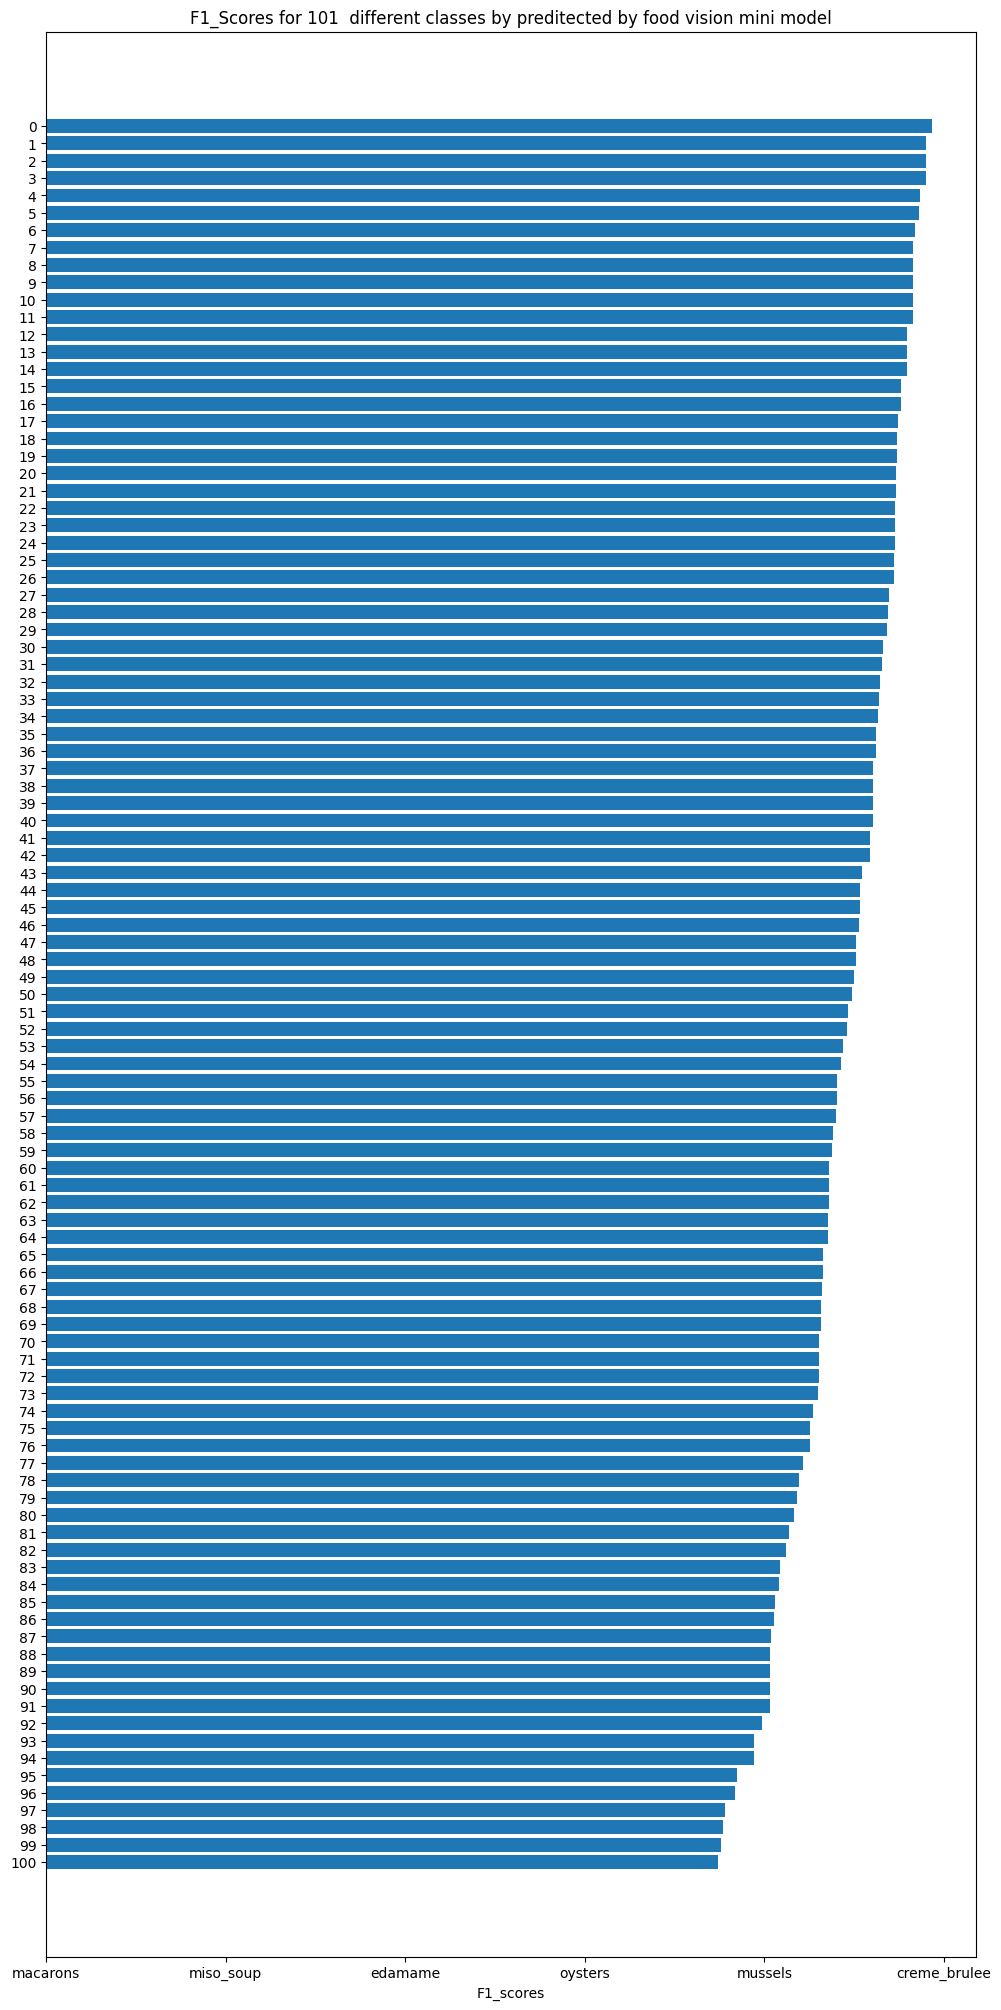

In [ ]:
import matplotlib.pyplot as plt


fig,ax=plt.subplots(figsize=(12,25))
scores=ax.barh(range(len(f1_scores)),f1_scores['f1_score'].values) #get f1-score values
ax.set_yticks(range(len(f1_scores)))
ax.set_xticklabels(f1_scores['class_names'])
ax.set_xlabel('F1_scores')
ax.set_title('F1_Scores for 101  different classes by preditected by food vision mini model')
ax.invert_yaxis(); #Reverse the order of our plot

# Challege: Add values to the end of each bar of what the actual f1-score is
# (hint:use the 'autolabel' function from here:https://matplotlib.org/2.0.2/examples/api/barchart_demo.html)



⚒ **Execrises:** Try visualising some of the most poorly predicted classes(e.g. `apple_pie`,`pork_chip`,do you notice any among them? Why might our model be having trouble with them?


### Visualizing predictions on test images
Now , this is the real test, how does our model go on food images not even in our test dataset (images of our own).

To visualise the models predictions on our images, we'll need a function to load and preprocess images,specifically it will need to:
* Read in a target image filepath using `tf.io.read_file()`
* Turn the images into a tensor using `tf.io.decode_file()`
* Resize the image tensor to be the same size as the images our model has trained on using `tf.image.resize()`
* Scale the image to get all of the pixel values between 0 & 1
(if necessary)

In [ ]:
#Create a function to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image file and turns it into a tensor
  specified image (img_shape,img_shape,3) 3 for RGB color channels

  Args:
     filename(str):path to the image file
     img_shape(int):Height/width dimension of the target image size
     scale(bool):whether scale pixel values from 0-255 to 0-1 or not by default set to True

  Returns:
     Image tensor of shape(img_shape,img_shape,3)
  """
  #Read in the target image
  img=tf.io.read_file(filename)

  #Decode image into tensor
  img=tf.io.decode_image(img,channels=3)

  #Resize the image
  img=tf.image.resize(img,[img_shape,img_shape])

  #Scale
  if scale:
    #Rescale the image (get all values between 0 and 1)
    return img/255
  else:
    return img # don't need to rescale images for EfficientNet models in Tensorflow



Now we've got a function to load and prepare target images, let's now write some code to visualise images, their target labels and our models predictions.

Specifically, we'll some code to:
1. Load a few random images from the test dataset
2. Make predictions on loaded images
3. Plot the original images along with the model predictions ,prediction probability and true label.

101_food_classes_10_percent/test/poutine/2089991.jpg
1/1 [==============================] - 2s 2s/step
[[0.02270793 0.00587023 0.03042848 0.00504349 0.02393965 0.02045795
  0.0533122  0.00206704 0.01492382 0.00057694 0.00073831 0.00029336
  0.00241174 0.008702   0.00531886 0.00607057 0.01768366 0.02013704
  0.00466829 0.02087786 0.02444182 0.01690459 0.04719204 0.02113187
  0.01167445 0.00039096 0.00021813 0.0075145  0.0009035  0.0262648
  0.01337819 0.00219365 0.00526481 0.04501755 0.00011875 0.00070576
  0.00061665 0.00853649 0.00088301 0.03277709 0.03988451 0.00614071
  0.00844848 0.00504016 0.00219151 0.00185939 0.000552   0.0020032
  0.00033938 0.00304834 0.00186315 0.02046634 0.00779983 0.00110683
  0.00308549 0.00033073 0.00036204 0.0003624  0.00981571 0.00836937
  0.00688227 0.00155558 0.00832166 0.01476085 0.11419959 0.0001522
  0.00844373 0.00034707 0.001512   0.00078492 0.00096327 0.00123892
  0.0007926  0.01328319 0.00538786 0.00168436 0.01505599 0.00363334
  0.00036428 0.0

<Figure size 1000x1000 with 0 Axes>

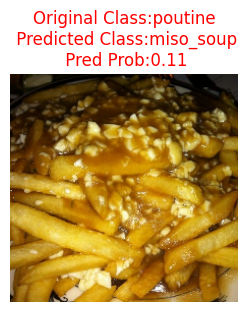

101_food_classes_10_percent/test/bibimbap/1144582.jpg
1/1 [==============================] - 0s 27ms/step
[[0.0225994  0.005838   0.03025525 0.00502774 0.02400918 0.02040344
  0.05320974 0.00207836 0.01485482 0.0005791  0.00073937 0.00029607
  0.0024219  0.00873515 0.00532391 0.00603934 0.01768803 0.02013014
  0.00471188 0.02105    0.02440639 0.0170006  0.04686515 0.02116343
  0.01168122 0.00038975 0.00021762 0.0075023  0.00090457 0.02639217
  0.01334667 0.00221723 0.00525332 0.04474717 0.00011882 0.00071106
  0.00061591 0.00853001 0.00088402 0.03278785 0.03989217 0.00610284
  0.00845352 0.00503161 0.00220103 0.00186663 0.0005515  0.00201099
  0.00034318 0.00305959 0.00188023 0.02051948 0.00781584 0.0011085
  0.00308444 0.00033335 0.00036613 0.00036426 0.009849   0.00839567
  0.00686727 0.00155174 0.00832179 0.01488594 0.11447874 0.00015407
  0.00842268 0.00034978 0.00150915 0.00078875 0.00096652 0.00124464
  0.00079401 0.01333666 0.00534959 0.00169718 0.01511723 0.00362058
  0.0003634

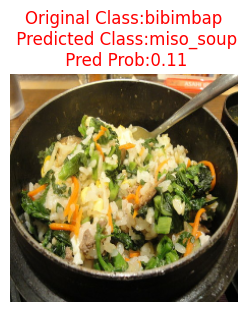

101_food_classes_10_percent/test/french_fries/2248373.jpg
1/1 [==============================] - 0s 27ms/step
[[0.02272345 0.00587473 0.03042513 0.0050531  0.02389268 0.0204928
  0.0533853  0.00206565 0.014935   0.00057673 0.0007368  0.00029187
  0.0024075  0.00871554 0.00531502 0.00608491 0.01762921 0.02010932
  0.00466305 0.02086199 0.02446888 0.01683904 0.04728949 0.02108891
  0.01165449 0.0003907  0.00021735 0.00752702 0.000902   0.02623367
  0.01336981 0.00218276 0.00527576 0.04512557 0.0001186  0.00070297
  0.00061582 0.00850909 0.00088193 0.03265822 0.03993526 0.00614898
  0.0084437  0.00504254 0.00218911 0.00185738 0.00055127 0.00199796
  0.00033799 0.00304577 0.00185214 0.02044652 0.0078136  0.0011051
  0.00308174 0.0003294  0.00036021 0.00036109 0.00980919 0.00837585
  0.00688128 0.00155742 0.00830478 0.01470987 0.11412908 0.00015147
  0.00844837 0.00034629 0.00151439 0.00078385 0.00095993 0.00123793
  0.00079125 0.01322896 0.00540287 0.00168199 0.01506163 0.00363956
  0.0003

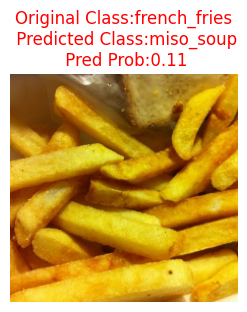

In [ ]:
#MAke pred on a series of random images
import os
import random
import numpy as np

plt.figure(figsize=(10,10))
for i in range(3):
  #Choose a random image from random class
  class_name=random.choice(class_names)
  #print(class_name)
  filename=random.choice(os.listdir(test_dir+'/'+class_name))
  #print(filename)
  file_path=os.path.join(test_dir,class_name,filename)
  #print(file_path)

  #load the image and make predictions
  img=load_and_prep_image(file_path)
  print(file_path)
  pred_prob=model.predict(tf.expand_dims(img,axis=0)) #get prediction probabilities array
  print(pred_prob)
  pred_class=class_names[np.argmax(pred_prob)] #get highest prediction probability index
  #print(f"Original Class:{class_name}")
  #print(f"Predicted Class:{pred_class}")

  #Plot the images
  plt.figure(figsize=(10,10))
  plt.subplot(1,3,i+1)
  plt.imshow(img)
  if class_name==pred_class:#if predcited class matches truth class,make text green
     title_color='g'
  else:
    title_color='r'
  plt.title(f"Original Class:{class_name}\n Predicted Class:{pred_class}\n Pred Prob:{pred_prob.max():.2f}",c=title_color)
  plt.axis(False)
  plt.show()


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread(file_path)
img=tf.image.resize(img,[224,224])

In [ ]:
pred_prob=model.predict(tf.expand_dims(img,axis=0))
pred_class=class_names[np.argmax(pred_prob)]
pred_class

1/1 [==============================] - 0s 25ms/step


'french_fries'

## TO Finding the most wrong predictions

TO find out where our models is most wrong,lets write some code to find out the following:
1. Get all of the image file paths in the test dataset using `list_files()` method
2. Create a pandas dataframe of the image filepaths,ground truth labels,predicted classes(from our model),max prediction probabilites.
3. Use our DataFrame to find the all the wrong predictions.
4. Sort the dataframe based on wrong predictions (have the highest wrong predictions at the top).
5. Visualise the top 10 wrong predictions.


In [ ]:
# 1.Get all of the image file paths in the test dataset
file_paths=[]
for file_path in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                      shuffle=False):
  file_paths.append(file_path.numpy()) #Adding file_path
file_paths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
len(file_paths),len(y_labels),len(pred_classes),len(pred_prob)

(25250, 7575, 7575, 1)

In [ ]:
# 2. Create a dataframe of different parameters for each of our test images
import pandas as pd
pred_df=pd.DataFrame({"img_path":file_paths,
                      'y_true':y_labels,
                      'y_pred':pred_classes,
                      'pred_conf':pred_prob.max(axis=1),#Get the maximum prediction probabilities
                      'y_true_classnames':[class_names[i] for i in y_labels],
                      'y_pred_classnames':[class_names[i] for i in pred_classes]})
pred_df.head()

ValueError: All arrays must be of the same length

In [ ]:
# 3. Find out in a dataframe which predictions are wrong
pred_df['pred_correct']=pred_df['y_true']==pred_df['y_pred']
pred_df.head()

In [ ]:
# 4. Sort our dataframe to have most wrong predictions at the top
top_100_wrong=pred_df[pred_df['pred_correct']==False].sort_values(by='pred_conf',ascending=False)[:100]
top_100_wrong.head()

In [ ]:
# 5. Visualise the test data samples which have the wrong predictions but highest prediction probabilities.
images_to_view=9
start_index=0
plt.figure(figsize=(10,10))
for i,row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img=load_and_pred_image(row[1],scale=False)
  _,_,_,_,pred_prob,y_true_class,y_pred_class,_=row # only interested in a few parameters of each row
  plt.imshow(img/255)
  plt.title(f"Actual Class:{y_true_class},\n pred:{y_pred_class},\n pred_prob:{pred_prob:.2f}")
  plt.axis(False)


## Test out the big dog model our own cusom images

In [ ]:
#Get the custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data('custom_food_images.zip')

In [ ]:
#Get the custom food filepaths
custom_food_images_paths=["custom_food_images/"+img_path for img_path in os.listdir('custom_food_images')]
custom_food_images_paths


In [ ]:
# Make predicitions on and plot custom food images
for img in custom_food_images_path:
  img=load_and_prep_image(img,scale=False) #Don't need to scale for EfficientNetB0 Model
  pred_prob=model.predict(tf.expand_dims(img,axis=0))
  pred_class=class_names[np.argmax(pred_prob)] # get the index with the highest predictions probability
  #Plot the appropiate info
  plt.figure()
  plt.imshow(img/255)
  plt.title(f'Predicted Class:{pred_class},Prob:{pred_prob.max():.2f}')
  plt.axis(False)

